In [5]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q gymnasium torch matplotlib

import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import pickle
import os
import matplotlib.pyplot as plt
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

results_path = '/content/drive/MyDrive/RL_HW2_Results'
os.makedirs(results_path, exist_ok=True)
print(f"Results will be saved to: {results_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
Results will be saved to: /content/drive/MyDrive/RL_HW2_Results


In [9]:
best_configs = {
    'dqn': {'lr': 0.01, 'batch_size': 16, 'buffer_size': 2000, 'gamma': 0.99},
    'reinforce': {'lr': 0.003, 'gamma': 0.99},
    'a2c': {'lr': 0.003, 'gamma': 0.99}
}

with open(f'{results_path}/best_hyperparameters.json', 'w') as f:
    json.dump(best_configs, f, indent=2)

print("Hyperparameters saved!")
print(json.dumps(best_configs, indent=2))

Hyperparameters saved!
{
  "dqn": {
    "lr": 0.01,
    "batch_size": 16,
    "buffer_size": 2000,
    "gamma": 0.99
  },
  "reinforce": {
    "lr": 0.003,
    "gamma": 0.99
  },
  "a2c": {
    "lr": 0.003,
    "gamma": 0.99
  }
}


In [6]:
class SharedNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128, output_dim=2):
        super(SharedNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, lr=0.01, gamma=0.99, batch_size=16, buffer_size=2000):
        self.q_network = SharedNetwork(4, 128, 2).to(device)
        self.target_network = SharedNetwork(4, 128, 2).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return q_values.argmax().item()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values.squeeze(), target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

def train_dqn(seed=0, lr=0.01, batch_size=16, buffer_size=2000, max_episodes=800, verbose=False):
    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    agent = DQNAgent(lr=lr, batch_size=batch_size, buffer_size=buffer_size)
    episode_rewards = []

    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, float(done))
            agent.update()

            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)

        if episode % 100 == 0:
            agent.update_target_network()

        if verbose and episode % 200 == 0:
            print(f"Episode {episode}, Avg Reward: {np.mean(episode_rewards[-100:]):.2f}")

        if len(episode_rewards) >= 100 and np.mean(episode_rewards[-100:]) >= 475:
            if verbose:
                print(f"DQN converged at episode {episode}")
            break

    env.close()
    return episode_rewards

class REINFORCEAgent:
    def __init__(self, lr=0.003, gamma=0.99):
        self.policy_network = SharedNetwork(4, 128, 2).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.gamma = gamma

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        logits = self.policy_network(state_tensor)
        probs = torch.softmax(logits, dim=1)
        action = torch.multinomial(probs, 1).item()
        return action, torch.log(probs[0, action])

    def update(self, log_probs, rewards):
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = torch.FloatTensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)

        loss = torch.stack(policy_loss).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

def train_reinforce(seed=0, lr=0.003, max_episodes=500, verbose=False):
    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    agent = REINFORCEAgent(lr=lr)
    episode_rewards = []

    for episode in range(max_episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False

        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state

        agent.update(log_probs, rewards)
        episode_rewards.append(sum(rewards))

        if verbose and episode % 200 == 0:
            print(f"Episode {episode}, Avg Reward: {np.mean(episode_rewards[-100:]):.2f}")

        if len(episode_rewards) >= 100 and np.mean(episode_rewards[-100:]) >= 475:
            if verbose:
                print(f"REINFORCE converged at episode {episode}")
            break

    env.close()
    return episode_rewards

class A2CAgent:
    def __init__(self, lr=0.003, gamma=0.99):
        self.actor = SharedNetwork(4, 128, 2).to(device)
        self.critic = SharedNetwork(4, 128, 1).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.gamma = gamma

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        logits = self.actor(state_tensor)
        probs = torch.softmax(logits, dim=1)
        action = torch.multinomial(probs, 1).item()
        return action

    def update(self, state, action, reward, next_state, done):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)

        value = self.critic(state_tensor)
        next_value = self.critic(next_state_tensor)

        td_target = reward + (1 - float(done)) * self.gamma * next_value.item()
        advantage = td_target - value.item()

        critic_loss = (td_target - value) ** 2
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        logits = self.actor(state_tensor)
        probs = torch.softmax(logits, dim=1)
        log_prob = torch.log(probs[0, action])
        actor_loss = -log_prob * advantage

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

def train_a2c(seed=0, lr=0.003, max_episodes=500, verbose=False):
    env = gym.make('CartPole-v1')
    env.reset(seed=seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    agent = A2CAgent(lr=lr)
    episode_rewards = []

    for episode in range(max_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.update(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward

        episode_rewards.append(episode_reward)

        if verbose and episode % 200 == 0:
            print(f"Episode {episode}, Avg Reward: {np.mean(episode_rewards[-100:]):.2f}")

        if len(episode_rewards) >= 100 and np.mean(episode_rewards[-100:]) >= 475:
            if verbose:
                print(f"A2C converged at episode {episode}")
            break

    env.close()
    return episode_rewards

In [3]:
def run_dqn_experiments(start_run=0, end_run=100):
    """Run DQN experiments from start_run to end_run"""
    import time

    print("=" * 60)
    print(f"RUNNING DQN: Runs {start_run} to {end_run-1}")
    print("=" * 60)

    start_time = time.time()

    for run in range(start_run, end_run):
        # Check if already exists
        save_path = f'{results_path}/dqn_run_{run}.pkl'
        if os.path.exists(save_path):
            print(f"  Run {run} already exists, skipping...")
            continue

        run_start = time.time()
        rewards = train_dqn(seed=run, verbose=False, lr=0.01, batch_size=16, buffer_size=2000, max_episodes=800)

        with open(save_path, 'wb') as f:
            pickle.dump(rewards, f)

        run_time = time.time() - run_start
        if run % 5 == 0:
            elapsed = time.time() - start_time
            print(f"  Run {run}/{end_run} | Time: {run_time:.1f}s | Total: {elapsed/60:.1f}m")

    total_time = time.time() - start_time
    print(f"\nDQN completed! Total time: {total_time/60:.1f} minutes")


run_dqn_experiments(start_run=0, end_run=100)


RUNNING DQN: Runs 0 to 99


/tmp/ipython-input-3469292375.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


  Run 0/100 | Time: 89.1s | Total: 1.5m
  Run 5/100 | Time: 119.2s | Total: 12.3m
  Run 10/100 | Time: 125.2s | Total: 20.7m
  Run 15/100 | Time: 94.6s | Total: 29.1m
  Run 20/100 | Time: 153.5s | Total: 40.1m
  Run 25/100 | Time: 128.3s | Total: 47.9m
  Run 30/100 | Time: 173.0s | Total: 56.7m
  Run 35/100 | Time: 70.6s | Total: 63.5m
  Run 40/100 | Time: 102.0s | Total: 75.6m
  Run 45/100 | Time: 84.3s | Total: 82.8m
  Run 50/100 | Time: 80.9s | Total: 91.5m
  Run 55/100 | Time: 143.1s | Total: 102.3m
  Run 60/100 | Time: 68.2s | Total: 111.9m
  Run 65/100 | Time: 85.0s | Total: 120.1m
  Run 70/100 | Time: 89.2s | Total: 129.3m
  Run 75/100 | Time: 80.1s | Total: 138.9m
  Run 80/100 | Time: 134.0s | Total: 148.5m
  Run 85/100 | Time: 126.1s | Total: 157.9m
  Run 90/100 | Time: 121.8s | Total: 165.5m
  Run 95/100 | Time: 77.1s | Total: 173.7m

DQN completed! Total time: 181.3 minutes


In [4]:
def run_reinforce_experiments(start_run=0, end_run=100):
    """Run REINFORCE experiments from start_run to end_run"""
    import time

    print("=" * 60)
    print(f"RUNNING REINFORCE: Runs {start_run} to {end_run-1}")
    print("=" * 60)

    start_time = time.time()

    for run in range(start_run, end_run):
        save_path = f'{results_path}/reinforce_run_{run}.pkl'
        if os.path.exists(save_path):
            print(f"  Run {run} already exists, skipping...")
            continue

        run_start = time.time()
        rewards = train_reinforce(seed=run, verbose=False, lr=0.003, max_episodes=500)

        with open(save_path, 'wb') as f:
            pickle.dump(rewards, f)

        run_time = time.time() - run_start
        if run % 5 == 0:
            elapsed = time.time() - start_time
            print(f"  Run {run}/{end_run} | Time: {run_time:.1f}s | Total: {elapsed/60:.1f}m")

    total_time = time.time() - start_time
    print(f"\nREINFORCE completed! Total time: {total_time/60:.1f} minutes")


run_reinforce_experiments(start_run=0, end_run=100)


RUNNING REINFORCE: Runs 0 to 99
  Run 0/100 | Time: 49.0s | Total: 0.8m
  Run 5/100 | Time: 36.6s | Total: 4.7m
  Run 10/100 | Time: 30.5s | Total: 8.4m
  Run 15/100 | Time: 46.5s | Total: 13.2m
  Run 20/100 | Time: 37.6s | Total: 17.1m
  Run 25/100 | Time: 31.9s | Total: 21.7m
  Run 30/100 | Time: 28.2s | Total: 25.4m
  Run 35/100 | Time: 66.2s | Total: 28.8m
  Run 40/100 | Time: 37.4s | Total: 32.6m
  Run 45/100 | Time: 58.4s | Total: 36.7m
  Run 50/100 | Time: 54.1s | Total: 41.0m
  Run 55/100 | Time: 55.2s | Total: 44.3m
  Run 60/100 | Time: 71.0s | Total: 49.3m
  Run 65/100 | Time: 71.3s | Total: 52.9m
  Run 70/100 | Time: 32.4s | Total: 57.5m
  Run 75/100 | Time: 44.7s | Total: 61.3m
  Run 80/100 | Time: 64.6s | Total: 65.7m
  Run 85/100 | Time: 44.2s | Total: 69.0m
  Run 90/100 | Time: 47.5s | Total: 73.2m
  Run 95/100 | Time: 50.9s | Total: 77.7m

REINFORCE completed! Total time: 80.1 minutes


In [7]:
# ============================================================================
# SESSION 3: RUN A2C ONLY (100 runs)
# ============================================================================

def run_a2c_experiments(start_run=0, end_run=100):
    """Run A2C experiments from start_run to end_run"""
    import time

    print("=" * 60)
    print(f"RUNNING A2C: Runs {start_run} to {end_run-1}")
    print("=" * 60)

    start_time = time.time()

    for run in range(start_run, end_run):
        save_path = f'{results_path}/a2c_run_{run}.pkl'
        if os.path.exists(save_path):
            print(f"  Run {run} already exists, skipping...")
            continue

        run_start = time.time()
        rewards = train_a2c(seed=run, verbose=False, lr=0.003, max_episodes=500)

        with open(save_path, 'wb') as f:
            pickle.dump(rewards, f)

        run_time = time.time() - run_start
        if run % 5 == 0:
            elapsed = time.time() - start_time
            print(f"  Run {run}/{end_run} | Time: {run_time:.1f}s | Total: {elapsed/60:.1f}m")

    total_time = time.time() - start_time
    print(f"\nA2C completed! Total time: {total_time/60:.1f} minutes")


run_a2c_experiments(start_run=0, end_run=100)


RUNNING A2C: Runs 0 to 99
  Run 0/100 | Time: 19.1s | Total: 0.3m
  Run 5/100 | Time: 21.5s | Total: 2.1m
  Run 10/100 | Time: 17.7s | Total: 3.6m
  Run 15/100 | Time: 18.7s | Total: 5.2m
  Run 20/100 | Time: 18.0s | Total: 6.7m
  Run 25/100 | Time: 18.5s | Total: 8.6m
  Run 30/100 | Time: 24.1s | Total: 10.3m
  Run 35/100 | Time: 17.2s | Total: 12.9m
  Run 40/100 | Time: 17.9s | Total: 14.5m
  Run 45/100 | Time: 17.0s | Total: 16.6m
  Run 50/100 | Time: 17.2s | Total: 18.2m
  Run 55/100 | Time: 19.9s | Total: 20.1m
  Run 60/100 | Time: 18.8s | Total: 21.6m
  Run 65/100 | Time: 18.0s | Total: 23.1m
  Run 70/100 | Time: 19.0s | Total: 25.8m
  Run 75/100 | Time: 17.4s | Total: 27.4m
  Run 80/100 | Time: 88.7s | Total: 30.1m
  Run 85/100 | Time: 19.0s | Total: 31.6m
  Run 90/100 | Time: 17.8s | Total: 33.6m
  Run 95/100 | Time: 18.1s | Total: 35.1m

A2C completed! Total time: 36.3 minutes


STATISTICAL ANALYSIS

DQN:
  Final Reward: 103.52 ± 73.80
  Avg Episodes: 800.0

REINFORCE:
  Final Reward: 246.78 ± 191.87
  Avg Episodes: 482.4

A2C:
  Final Reward: 9.35 ± 0.80
  Avg Episodes: 500.0


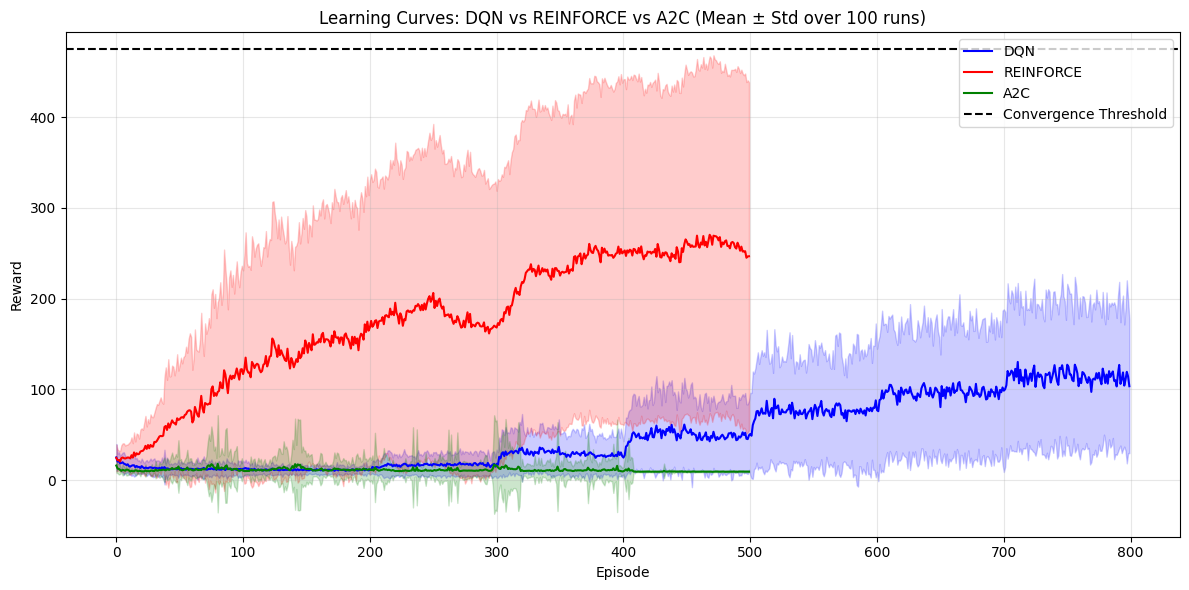



Results saved to: /content/drive/MyDrive/RL_HW2_Results


In [8]:
def analyze_and_plot_results(num_runs=100):
    """Generating plots"""

    print("=" * 60)
    print("STATISTICAL ANALYSIS")
    print("=" * 60)

    algorithms = ['dqn', 'reinforce', 'a2c']
    results = {}

    for algo in algorithms:
        all_rewards = []
        for run in range(num_runs):
            file_path = f'{results_path}/{algo}_run_{run}.pkl'
            if os.path.exists(file_path):
                with open(file_path, 'rb') as f:
                    rewards = pickle.load(f)
                    all_rewards.append(rewards)

        if len(all_rewards) == 0:
            print(f"{algo.upper()}: No results found!")
            continue

        max_len = max(len(r) for r in all_rewards)
        padded_rewards = []
        for r in all_rewards:
            if len(r) < max_len:
                padded = r + [r[-1]] * (max_len - len(r))
            else:
                padded = r
            padded_rewards.append(padded)

        mean_rewards = np.mean(padded_rewards, axis=0)
        std_rewards = np.std(padded_rewards, axis=0)

        final_rewards = [r[-1] for r in all_rewards]
        episodes_to_converge = [len(r) for r in all_rewards]

        results[algo] = {
            'mean': mean_rewards,
            'std': std_rewards,
            'final_mean': np.mean(final_rewards),
            'final_std': np.std(final_rewards),
            'avg_episodes': np.mean(episodes_to_converge)
        }

        print(f"\n{algo.upper()}:")
        print(f"  Final Reward: {results[algo]['final_mean']:.2f} ± {results[algo]['final_std']:.2f}")
        print(f"  Avg Episodes: {results[algo]['avg_episodes']:.1f}")


    plt.figure(figsize=(12, 6))
    colors = {'dqn': 'blue', 'reinforce': 'red', 'a2c': 'green'}

    for algo in algorithms:
        if algo not in results:
            continue
        episodes = range(len(results[algo]['mean']))
        plt.plot(episodes, results[algo]['mean'], label=f'{algo.upper()}', color=colors[algo])
        plt.fill_between(episodes,
                         results[algo]['mean'] - results[algo]['std'],
                         results[algo]['mean'] + results[algo]['std'],
                         alpha=0.2, color=colors[algo])

    plt.axhline(y=475, color='black', linestyle='--', label='Convergence Threshold')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Learning Curves: DQN vs REINFORCE vs A2C (Mean ± Std over 100 runs)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{results_path}/learning_curves_comparison.png', dpi=300)
    plt.show()

    # Save stats
    stats_summary = {algo: {
        'final_mean_reward': float(results[algo]['final_mean']),
        'final_std_reward': float(results[algo]['final_std']),
        'avg_episodes_to_converge': float(results[algo]['avg_episodes'])
    } for algo in results}

    with open(f'{results_path}/statistical_summary.json', 'w') as f:
        json.dump(stats_summary, f, indent=2)

    print(f"\n\nResults saved to: {results_path}")
    return results


results = analyze_and_plot_results(num_runs=100)
